In [52]:
import Search, Intent, Identity, Transaction, Event
from Search import Similarity

import os

from joblib import dump, load
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import matplotlib.pyplot as plt


In [53]:
# import csv
# lines = []
# with open("./resources/model_data/COMP3074-CW1-Dataset_500.csv", 'r', encoding ='utf-8 ') as f:
#     reader = csv.DictReader(f)
#     for i, line in enumerate(reader):
#         for(k,v) in line.items():
#             match k:
#                 case 'Question':
#                     lines.append(v)
# print(lines)
# lines = [line+"\n"for line in lines]
# with open("./resources/model_data/intent-classification/question-answering.txt", 'w', encoding='utf-8') as g:
#     g.write("question\n")
#     g.writelines(lines)

In [54]:
# PICKLING FAILED ON THESE HALF OF THESE OBJECTS :(


# c = Search.CSV_QA(path='./resources/COMP3074-CW1-Dataset.csv')
# d = Search.TXT_Intent(folder_path='./resources/intent-classification')
# f = Identity.Identity(
#     path ='./resources/json/identities.json',
#     user=input("Welcome to the Auction House!\n"\
#     "Please enter your name(6 char max): ")[0:6])
# g = Transaction.Transaction(path ='./resources/json/items.json', identity=f)
# e = Intent.Intent(
#     intent_matcher=d, qa_searcher=c,
#     identity=f, transaction=g)
# h = Event.Event(f, g)

In [ ]:

class Evaluation:
    def __init__(self):
        # Performance: system evaluation
            # Routing
                # Intent Classification
                    # 2.3 in Lab 5
            # Search
                # QA Search: 2.3 in Lab 5
            # Entity Recognition
                # synonym resolution?
                    # synonym resolution should be hardcoded
                # Sentiment Analysis
                    # 2.3 in Lab 5

        # Usability(experience): user evaluation
            # 3.3.1 in Lab 5
            # evaluate based on 3.4
        self.c = Search.CSV_QA(path='./resources/test_data/graphquestions.training.csv') # PASS A DIFFERENT CSV
        self.folder_path = './resources/test_data/intent-classification'
        self.d = Search.TXT_Intent(folder_path=self.folder_path)
        self.f = Identity.IdentityManager(path ='./resources/json/identities.json', user="dummy_name")
        self.g = Transaction.TransactionManger(path ='./resources/json/items.json', identity=self.f)
        self.e = Intent.IntentManager(intent_matcher=self.d, qa_searcher=self.c, identity=self.f, transaction=self.g)
        self.transaction_intents = ['buy', 'sell', 'bounty', 'bid', 'transaction', 'search', 'steal']
    
    def evlauation_qa(self):
        correct_count = 0
        incorrect_string = [] # string formatted for outputting results
        
        incorrect_qs = {} # questions which had incorrect answers
        incorrect_as = {} # the incorrect answers produced for the above questions
        correct_as = {} # the ground truth correct answers for the above questions
        correct_positions = {} # the index values of the correct answers for the above questions(how far from top(0))
        
        incorrect_docs = []

        for doc, q in self.c.questions.items():
            search_results = self.c.search_qa(q)
            test_answer = search_results[0] # highest ranked answer
            
            if(self.c.answers[doc] == test_answer):
                correct_count+=1
            else:
                incorrect_docs.append(doc)

                incorrect_qs[doc] = self.c.questions[doc]
                incorrect_as[doc] = test_answer
                correct_as[doc] = self.c.answers[doc]
                correct_positions[doc] = self.c.search_qa(q).index(correct_as[doc])

                incorrect_string.append(f"{doc} | Q: {incorrect_qs[doc]} | Predicted Ans: {incorrect_as[doc]} | Actual Ans: {correct_as[doc]}")
        
        print(f"QA Classification Accuracy: {correct_count}/{len(self.c.answers)}\n")
        
        print(f"Incorrect QA pairs:")
        for qa_pair in incorrect_string:
            print(qa_pair)
        
        rank = float(1/2 + 1/2 + correct_count)
        mrr = rank/float(len(self.c.answers))
        print(f"\nMean Reciprocal Rank: {mrr}")
        print(f"Incorrect Positions from Top: {correct_positions}")

    def evlauation_intent(self):
        # read docs from file
            # map intents to docs somehow
        # predict new ones
        # confusion matrix
        actual_intents = []
        intent_labels = []
        files = []
        filenames = next(os.walk(self.folder_path),(None, None, []))[2]  # [] if no file | https://tinyurl.com/45cwzxw8
        
        for file in filenames:
            intent_file = file.split('.')[0]
            intent_labels.append(intent_file)
            # files_intent = {}
            # files[intent_file] = files_intent
            with open(self.folder_path+"/"+file, encoding ='utf8 ', errors ='ignore ', mode ='r') as text_data:
                for i, line in enumerate(text_data):
                    # files_intent['doc'+str(i)]["intent"] = intent_file
                    # files_intent['doc'+str(i)]['line'] = line.strip()
                    files.append(line.strip())
                    actual_intents.append(intent_file)
        
        print(files)
        print(actual_intents)
        pred_intents = []
        for file in files:
            # print(file)
            intent, score = self.d.search_intent(file)
            pred_intents.append(intent)
        print(pred_intents)
        
# REFERENCE: https://tinyurl.com/devnc2xb ===================================================================

        cm = metrics.confusion_matrix(
            actual_intents,
            pred_intents,
            labels=intent_labels
        )
        print("Confusion Matrix:\n", cm)
        
        precision = precision_score(actual_intents, pred_intents, labels=[0, 1, 2, 3], average=None)
        recall = recall_score(actual_intents, pred_intents, labels=[0, 1, 2, 3], average=None)
        print("Precision per class:", precision)
        print("Recall per class:", recall)

        macro_precision = precision_score(
            actual_intents, pred_intents, labels=[0, 1, 2, 3], average='macro')
        macro_recall = recall_score(actual_intents, pred_intents, labels=[
                                    0, 1, 2, 3], average='macro')
        micro_precision = precision_score(
            actual_intents, pred_intents, labels=[0, 1, 2, 3], average='micro')
        micro_recall = recall_score(actual_intents, pred_intents, labels=[
                                    0, 1, 2, 3], average='micro')
        print("Macro Precision:", macro_precision)
        print("Macro Recall:", macro_recall)
        print("Micro Precision:", micro_precision)
        print("Micro Recall:", micro_recall)
        # intents are in file
            # load in similar way to qa
                # if predicted intent is same name as file
                # then GG

    def evlauation_synonym_resolution(self):
        # need ground truth labels for synonym resolution 
        actual_intents = []
        intent_labels = []
        files = []
        filenames = next(os.walk("./resources/test_data/synonym-resolution"),(None, None, []))[2]  # [] if no file | https://tinyurl.com/45cwzxw8

        for file in filenames:
            intent_file = file.split('.')[0]
            intent_labels.append(intent_file)
            # files_intent = {}
            # files[intent_file] = files_intent
            with open('./resources/test_data/synonym-resolution'+"/"+file, encoding ='utf8 ', errors ='ignore ', mode ='r') as text_data:
                for i, line in enumerate(text_data):
                    # files_intent['doc'+str(i)]["intent"] = intent_file
                    # files_intent['doc'+str(i)]['line'] = line.strip()
                    files.append(line.strip())
                    actual_intents.append(intent_file)
        
        
        pred_intents = {

        }
        pred_intents = []
        
        for f in files:
            for intent in self.transaction_intents:    
                
                x = self.e.synonym_resolution(intent, f)
                # if pred_intents[f]["intent"] == intent: continue
                if  x == intent:
                    pred_intents.append(x)#pred_intents[f]["intent"] = intent
                    break # break when we get classification

                if intent == 'steal': pred_intents.append('_') # steal is last, if no classification by here then fail(because of above break)
        # print(len(actual_intents)) 
        # print(len(pred_intents))    
        print("Test-data:")
        print(files)
        print("Ground Truth:")
        print(actual_intents)
        print("Predictions:")
        print(pred_intents)

        corr_count = 0
        for i in range(len(actual_intents)):
            if actual_intents[i] == pred_intents[i]:  corr_count += 1
        print(f"Classification Accuracy: {float(corr_count/len(actual_intents))}")
# ==========================================================================================================

# Question Answering

In [56]:
import json
path = './resources/model_data/graphquestions.training.json'
with open(path, encoding ='utf8 ', errors ='ignore ', mode ='r') as json_file:
    file_json = json.load(json_file)
data = []

for x in file_json:
    qa = {

    }
    qa['Question'] = x['question'].strip()
    qa['Answer'] = x['answer'][0].strip()
    
    data.append(qa)

import csv
path2 = './resources/test_data/graphquestions.training.csv'
with open(path2, encoding ='utf8 ', errors ='ignore ', mode ='w', newline='') as csv_file:
    fieldnames = ['Question','Answer']
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
    writer.writeheader()
    writer.writerows(data[0:200])

data[0]

{'Question': 'find terrorist organizations involved in september 11 attacks.',
 'Answer': 'al-Qaeda'}

In [57]:
eval = Evaluation()
eval.evlauation_qa()

QA Classification Accuracy: 198/200

Incorrect QA pairs:
doc161 | Q: what type of distilled spirit is j & b? | Predicted Ans: Grain whisky | Actual Ans: Single malt Scotch whisky
doc164 | Q: j & b is which type of distilled spirit? | Predicted Ans: Single malt Scotch whisky | Actual Ans: Grain whisky

Mean Reciprocal Rank: 0.995
Incorrect Positions from Top: {'doc161': 1, 'doc164': 1}


# Sentiment Analysis

In [58]:
# REFERENCE: COMP3074_Lab2_Text_Classification__2025_ | https://moodle.nottingham.ac.uk/mod/resource/view.php?id=8254821 =======================================
label_dir = {
"positive": "./resources/train_data/sentiment/positive",
"negative": "./resources/train_data/sentiment/negative"
}

data = []
labels = []

for label in label_dir.keys():
    for file in os.listdir(label_dir[label]):
        filepath = label_dir[label]+os.sep+file
        with open(filepath, encoding ='utf8', errors ='ignore', mode ='r') as review:
            content = review.read()
            data.append(content)
            labels.append(label)

X_train, X_test, y_train, y_test = train_test_split(data, labels, stratify=labels, test_size=0.25, random_state=42)

count_vect = CountVectorizer(stop_words = stopwords.words('english'))
X_train_counts = count_vect.fit_transform(X_train)

tfidf_transformer = TfidfTransformer(use_idf=True, sublinear_tf=True).fit(X_train_counts)
X_train_tf = tfidf_transformer.transform(X_train_counts)

classifier = LogisticRegression(random_state =0).fit(X_train_tf, y_train)
pass


dump(classifier,'./resources/models/classifier.joblib')
dump(count_vect,'./resources/models/vectorizer.joblib')
dump(tfidf_transformer,'./resources/models/transformer.joblib')

# ========================================================================================================

['./resources/models/transformer.joblib']

Sensitivity: 0.8592964824120602
Specificity: 0.68


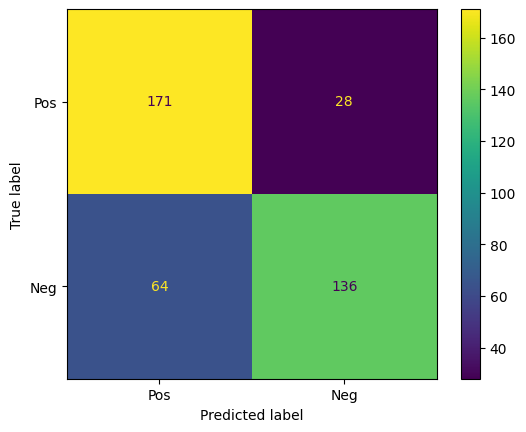

In [59]:
# REFERENCE: COMP3074_Lab2_Text_Classification__2025_ | https://moodle.nottingham.ac.uk/mod/resource/view.php?id=8254821 =======================================
label_dir_test = {
"positive": "./resources/test_data/sentiment/positive",
"negative": "./resources/test_data/sentiment/negative"
}

data = []
labels = []

for label in label_dir_test.keys():
    for file in os.listdir(label_dir_test[label]):
        filepath = label_dir_test[label]+os.sep+file
        with open(filepath, encoding ='utf8', errors ='ignore', mode ='r') as review:
            content = review.read()
            data.append(content)
            labels.append(label)


loaded_object = load('./resources/models/classifier.joblib')
processed_newdata = count_vect.transform(data)
processed_newdata = tfidf_transformer.transform(processed_newdata)

predictions = loaded_object.predict(processed_newdata)

confusion_matrix = metrics.confusion_matrix(labels, predictions)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Pos', 'Neg'])
cm_display.plot()

precision = float(171) / float(171 + 64) # TP / TP + FP
recall = float(171) / float(171 + 28) # TP / TP + FN

# We care about both pos and neg predictions equally
specificity = float(136) / float(136 + 64) # TN / TN + FP
sensitivity = recall

print(f"Sensitivity: {sensitivity}\nSpecificity: {specificity}")
plt.show()
# ========================================================================================================

# Intent Matching

In [60]:
cm  = eval.evlauation_intent()

['"who are you?"', '"all about what you can do"', '"what is your personality"', '"define yourself"', '"what are you"', '"say about what you can do"', '"introduce yourself"', '"describe yourself"', '"about yourself"', '"tell me about you"', '"tell me about yourself"', '"I want to know more about you"', '"I want to know you better"', '"talk some stuff about yourself"', '"tell me some stuff about you"', '"talk about yourself"', '"why are you here"', '"tell me what you can do"', '"who are you"', '"explain what you can do to me"', '"what dost thou do"', '"how do you work"', '"what are we doing here"', '"how does this work"', '"how does this thing work"', '"is this thing on?"', '"can you explain what you can do"', '"can you explan how you work"', '"can you please work"', '"please tell me what you can do"', '"bye"', '"see you"', '"I\'m out of here"', '"get me out of here"', '"bye bye now"', '"cyaaa"', '"catch you later"', '"cya later"', '"goodbye"', '"au revoir"', '"adios"', '"see ya"', '"bye

C:\Users\danie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\danie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\danie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:15

# Synonym Resolution

In [61]:
eval.evlauation_synonym_resolution()


bid
offer
bid
offer
tender
premium
buy
purchase
bargain
look
search
look
hunt
explore
sell
sell
steal
bargain
Test-data:
['bid', 'bet', 'offer', 'bidding', 'betting', 'offering', 'tender', 'submit', 'put undo', 'propose', 'reward', 'prize', 'award', 'recompense', 'renumeration', 'commision', 'premium', 'dividend', 'bounties', 'tip', 'buy', 'purchase', 'acquire', 'obtain', 'Deal', 'bargain', 'investment', 'acquire', 'acquisition', 'gain', 'look', 'inspect', 'search', 'determine', 'look', 'hunt', 'explore', 'scout', 'forage', 'scavenge', 'sell', 'dispose', 'ridden', 'sale', 'barter', 'exchange', 'remove', 'selling', 'removing', 'vend', 'steal', 'theft', 'loot', 'purloin', 'klepto', 'rob', 'burgle', 'pilfer', 'embezzle', 'Deal', 'business', 'agreement', 'undertaking', 'affair', 'arrangement', 'bargain', 'negotiation', 'treaty', 'contract']
Ground Truth:
['bid', 'bid', 'bid', 'bid', 'bid', 'bid', 'bid', 'bid', 'bid', 'bid', 'bounty', 'bounty', 'bounty', 'bounty', 'bounty', 'bounty', 'bount

# Usability Testing

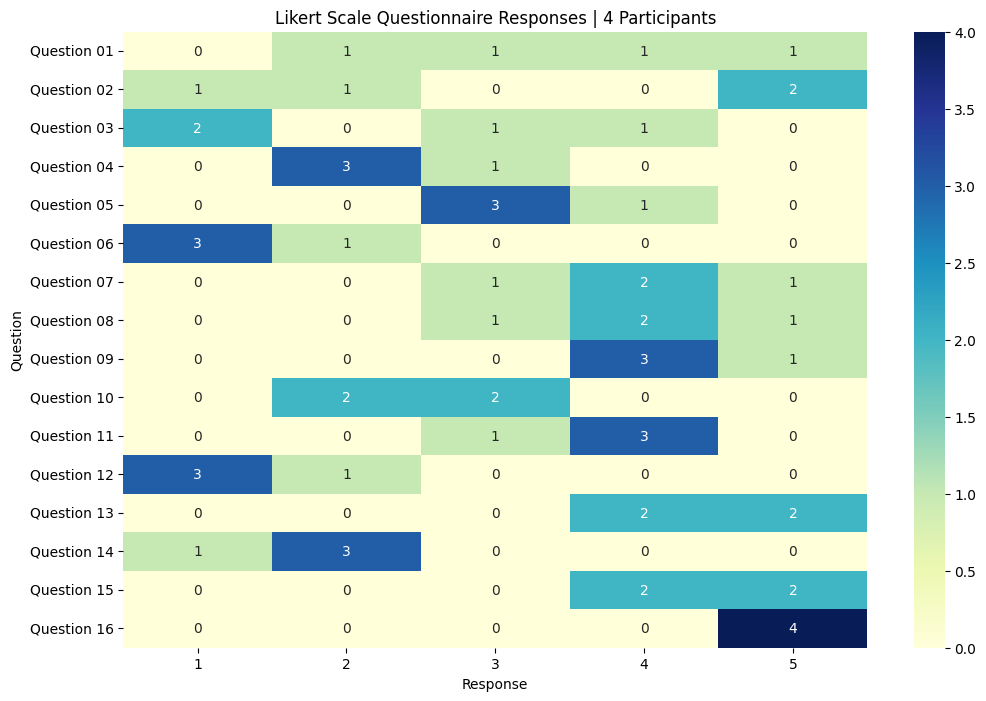

In [62]:
# REFERENCE: COMP3074_Lab5__2025___Short_.pdf | https://moodle.nottingham.ac.uk/mod/resource/view.php?id=8722118 =========================================================

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Sample data with responses from four participants for 16 questions
data = {
    'Question 01': [3, 5, 2, 4],
    'Question 02': [1, 5, 2, 5],
    'Question 03': [1, 3, 1, 4],
    'Question 04': [2, 2, 2, 3],
    'Question 05': [3, 3, 3, 4],
    'Question 06': [1, 1, 1, 2],
    'Question 07': [4, 4, 3, 5],
    'Question 08': [3, 4, 4, 5],
    'Question 09': [4, 4, 5, 4],
    'Question 10': [2, 3, 2, 3],
    'Question 11': [3, 4, 4, 4],
    'Question 12': [1, 1, 1, 2],
    'Question 13': [4, 4, 5, 5],
    'Question 14': [2, 1, 2, 2],
    'Question 15': [5, 5, 4, 4],
    'Question 16': [5, 5, 5, 5]
}

df = pd.DataFrame(data)

# Convert DataFrame to long format for easier plotting
df_long = df.melt(var_name ='Question', value_name ='Response')

# Create a pivot table for the heatmap
response_pivot = df_long.pivot_table(index ='Question', columns ='Response', aggfunc=len , fill_value=0)

# Create a heatmap
plt.figure(figsize =(12, 8))
sns.heatmap(response_pivot, annot=True, cmap="YlGnBu", fmt="d")
plt.title("Likert Scale Questionnaire Responses | 4 Participants")
plt.ylabel("Question")

plt.xlabel("Response")
plt.show()

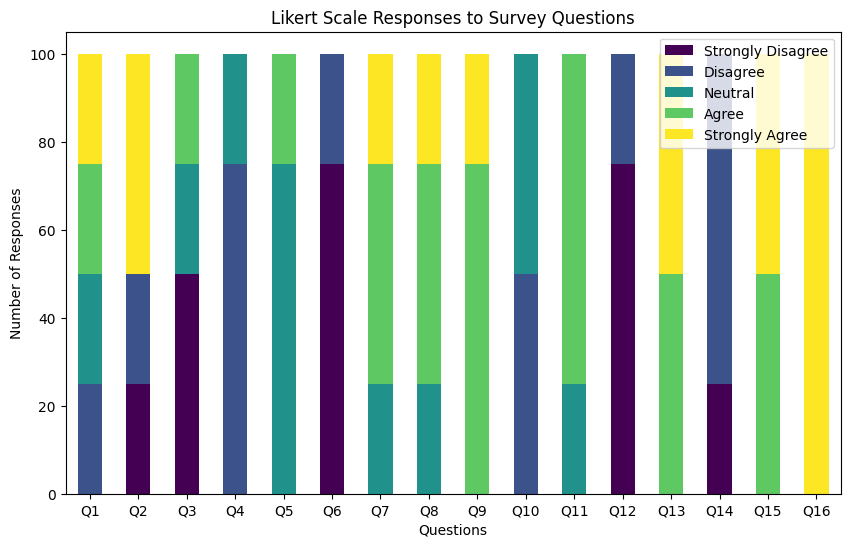

In [65]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample data : Responses to 16 questions on a Likert scale from 1 to 5
data = {
    'Strongly Disagree': [0, 25, 50, 0, 0, 75, 0, 0, 0, 0, 0, 75, 0, 25, 0, 0],
    'Disagree':          [25, 25, 0, 75, 0, 25, 0, 0, 0, 50, 0, 25, 0, 75, 0, 0],
    'Neutral':           [25, 0, 25, 25, 75, 0, 25, 25, 0, 50, 25, 0, 0, 0, 0, 0],
    'Agree':             [25, 0, 25, 0, 25, 0, 50, 50, 75, 0, 75, 0, 50, 0, 50, 0],
    'Strongly Agree ':   [25, 50, 0, 0, 0, 0, 25, 25, 25, 0, 0, 0, 50, 0, 50, 100]
}

df = pd.DataFrame(data, index=[f'Q{i+1}' for i in range (16)])

# Create a stacked bar chart
ax = df.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')

# Adding labels and title
plt.xlabel('Questions')
plt.ylabel('Number of Responses')
plt.title('Likert Scale Responses to Survey Questions')
plt.xticks(rotation=0)

# Display the chart
plt.show()
# ================================================================================================================================